# Prediction model of RRFs of compounds detected by GC/MS

## 0. Conception

*Which decision are we going to inform?* \
We will assist labs by predicting RRFs detected by GC/MS

*What is our prediction estimand?* \
Input data :  Several molecular and physico-chemical characteristics.
The outcome is continuous : Relative Response Factor

*How can you measure the model's success?* \
The model's success will be mostly assessed with the one having the highest R², lowest test MSE. \

### Loading Libraries

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chemistry
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# Scikit-learn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import plot_tree

sns.set(style="whitegrid")

# Hyperparameter tuning
import optuna

## 1. Data acquisition

The excel file was created by manually copying the table from the US FDA CLAP list and the table S1 supplementary data from Yun et al.


In [59]:
df = pd.read_excel('processed_data/RRFML.xlsx')

## 2. Exploratory data analysis

In [60]:
df.describe()


,DBE,MW,BP,logP,Refractive Index,5 µg/mL,10 µg/mL,20 µg/mL
count,92.000000,92.000000,91.000000,92.000000,89.000000,92.000000,92.000000,92.000000
mean,5.309783,303.179348,359.889011,6.055326,1.523247,0.374228,0.406674,0.412489
std,4.100953,160.177748,127.047844,4.117937,0.087404,0.463968,0.484548,0.446450
min,0.000000,102.200000,148.300000,-0.660000,1.289000,0.000000,0.000000,0.000000
25%,2.000000,195.550000,259.400000,3.142500,1.454000,0.030250,0.037250,0.053500
50%,4.000000,285.450000,359.400000,5.355000,1.499000,0.207000,0.287000,0.278000
75%,8.000000,375.600000,435.500000,8.475000,1.585000,0.534000,0.527000,0.608500
max,20.000000,1177.600000,779.000000,23.000000,1.757000,2.551000,2.143000,1.810000


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Code               92 non-null     object 
 1   IUPAC name         92 non-null     object 
 2   CAS #              92 non-null     object 
 3   Empirical Formula  92 non-null     object 
 4   DBE                92 non-null     float64
 5   MW                 92 non-null     float64
 6   BP                 91 non-null     float64
 7   pKa                65 non-null     object 
 8   logP               92 non-null     float64
 9   Refractive Index   89 non-null     float64
 10  5 µg/mL            92 non-null     float64
 11  10 µg/mL           92 non-null     float64
 12  20 µg/mL           92 non-null     float64
dtypes: float64(8), object(5)
memory usage: 9.5+ KB


## 3. Data preprocessing

We will first convert the CAS number of the extractables into Smiles using pubchem library. This is necessary to get molecular descriptors from the RdKit library.

In [62]:
def get_smiles_from_cas(cas):
    """Utility to fetch SMILES via PubChem"""
    try:
        results = pcp.get_compounds(cas, 'name')
        if results:
            return results[0].smiles
    except Exception as e:
        return None
    return None

df['SMILES'] = df['CAS #'].apply(get_smiles_from_cas)


This CAS number '68515-75-3' was manually added since the automation did not work.

In [63]:
target_cas = '68515-75-3'
manual_smiles = 'CCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'

df.loc[df['CAS #'] == target_cas, 'SMILES'] = manual_smiles


We will then convert the Smiles of the extractables into molecular descriptors using rdkit library.

In [64]:
def standardize_and_describe(smiles):
    if not smiles: return None
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    
    try:
        desc_names = [d[0] for d in Descriptors._descList]
        calculator = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)
        
        vals = calculator.CalcDescriptors(mol)
        return dict(zip(desc_names, vals))
        
    except:
        return None
    
results = df['SMILES'].apply(standardize_and_describe)
results[0]

{'MaxAbsEStateIndex': 14.09759139858905,
 'MaxEStateIndex': 14.09759139858905,
 'MinAbsEStateIndex': 0.06289968406320678,
 'MinEStateIndex': -1.583312103894714,
 'qed': 0.048539300020120885,
 'SPS': 13.176470588235293,
 'MolWt': 1177.6549999999986,
 'HeavyAtomMolWt': 1068.7909999999993,
 'ExactMolWt': 1176.7840788960002,
 'NumValenceElectrons': 472,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.3056426538791839,
 'MinPartialCharge': -0.5073406919509584,
 'MaxAbsPartialCharge': 0.5073406919509584,
 'MinAbsPartialCharge': 0.3056426538791839,
 'FpDensityMorgan1': 0.27058823529411763,
 'FpDensityMorgan2': 0.4,
 'FpDensityMorgan3': 0.5176470588235295,
 'BCUT2D_MWHI': 16.574293698696184,
 'BCUT2D_MWLOW': 9.777866684014993,
 'BCUT2D_CHGHI': 2.3902287655620653,
 'BCUT2D_CHGLO': -2.3165303063670226,
 'BCUT2D_LOGPHI': 2.4427158134677276,
 'BCUT2D_LOGPLOW': -2.4371075753690863,
 'BCUT2D_MRHI': 5.721410186883954,
 'BCUT2D_MRLOW': -0.17026478672952025,
 'AvgIpc': 2.425899834373451,
 'BalabanJ':

Get all predictors into columns instead of dictionary

In [65]:
df_final = df.join(df['SMILES'].apply(standardize_and_describe).apply(pd.Series))

In [66]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Columns: 231 entries, Code to fr_urea
dtypes: float64(225), object(6)
memory usage: 166.2+ KB


## EDA

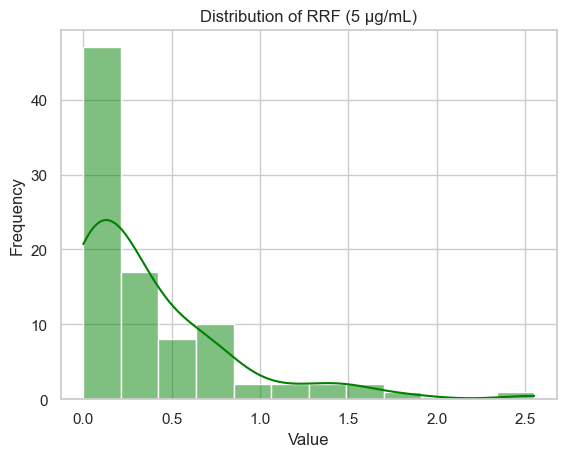

In [67]:
sns.histplot(df_final['5 µg/mL'], kde=True, color='green')
plt.title('Distribution of RRF (5 µg/mL)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

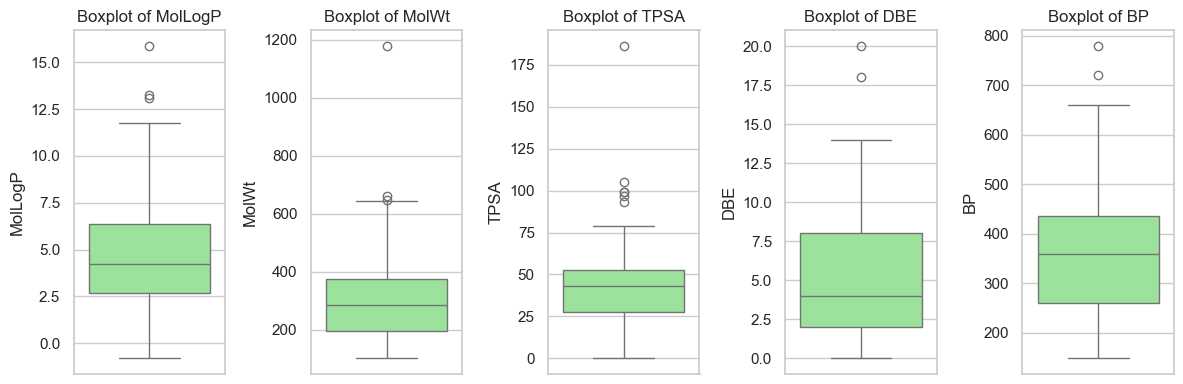

In [68]:
key_desc = ['MolLogP', 'MolWt', 'TPSA', 'DBE', 'BP']

plt.figure(figsize=(12, 4))
for i, col in enumerate(key_desc):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df_final[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

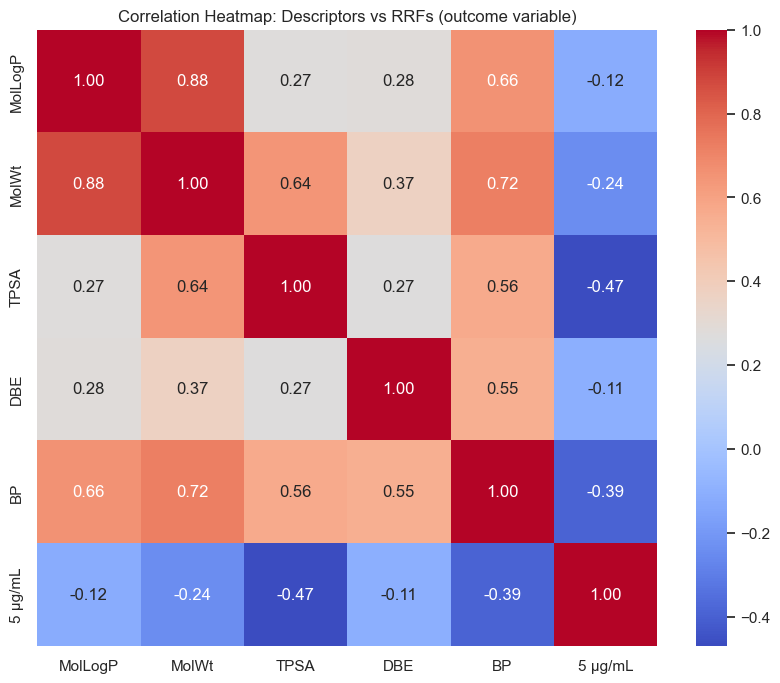

In [69]:
corr_matrix = df_final[key_desc + ['5 µg/mL']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Descriptors vs RRFs (outcome variable)')
plt.show()

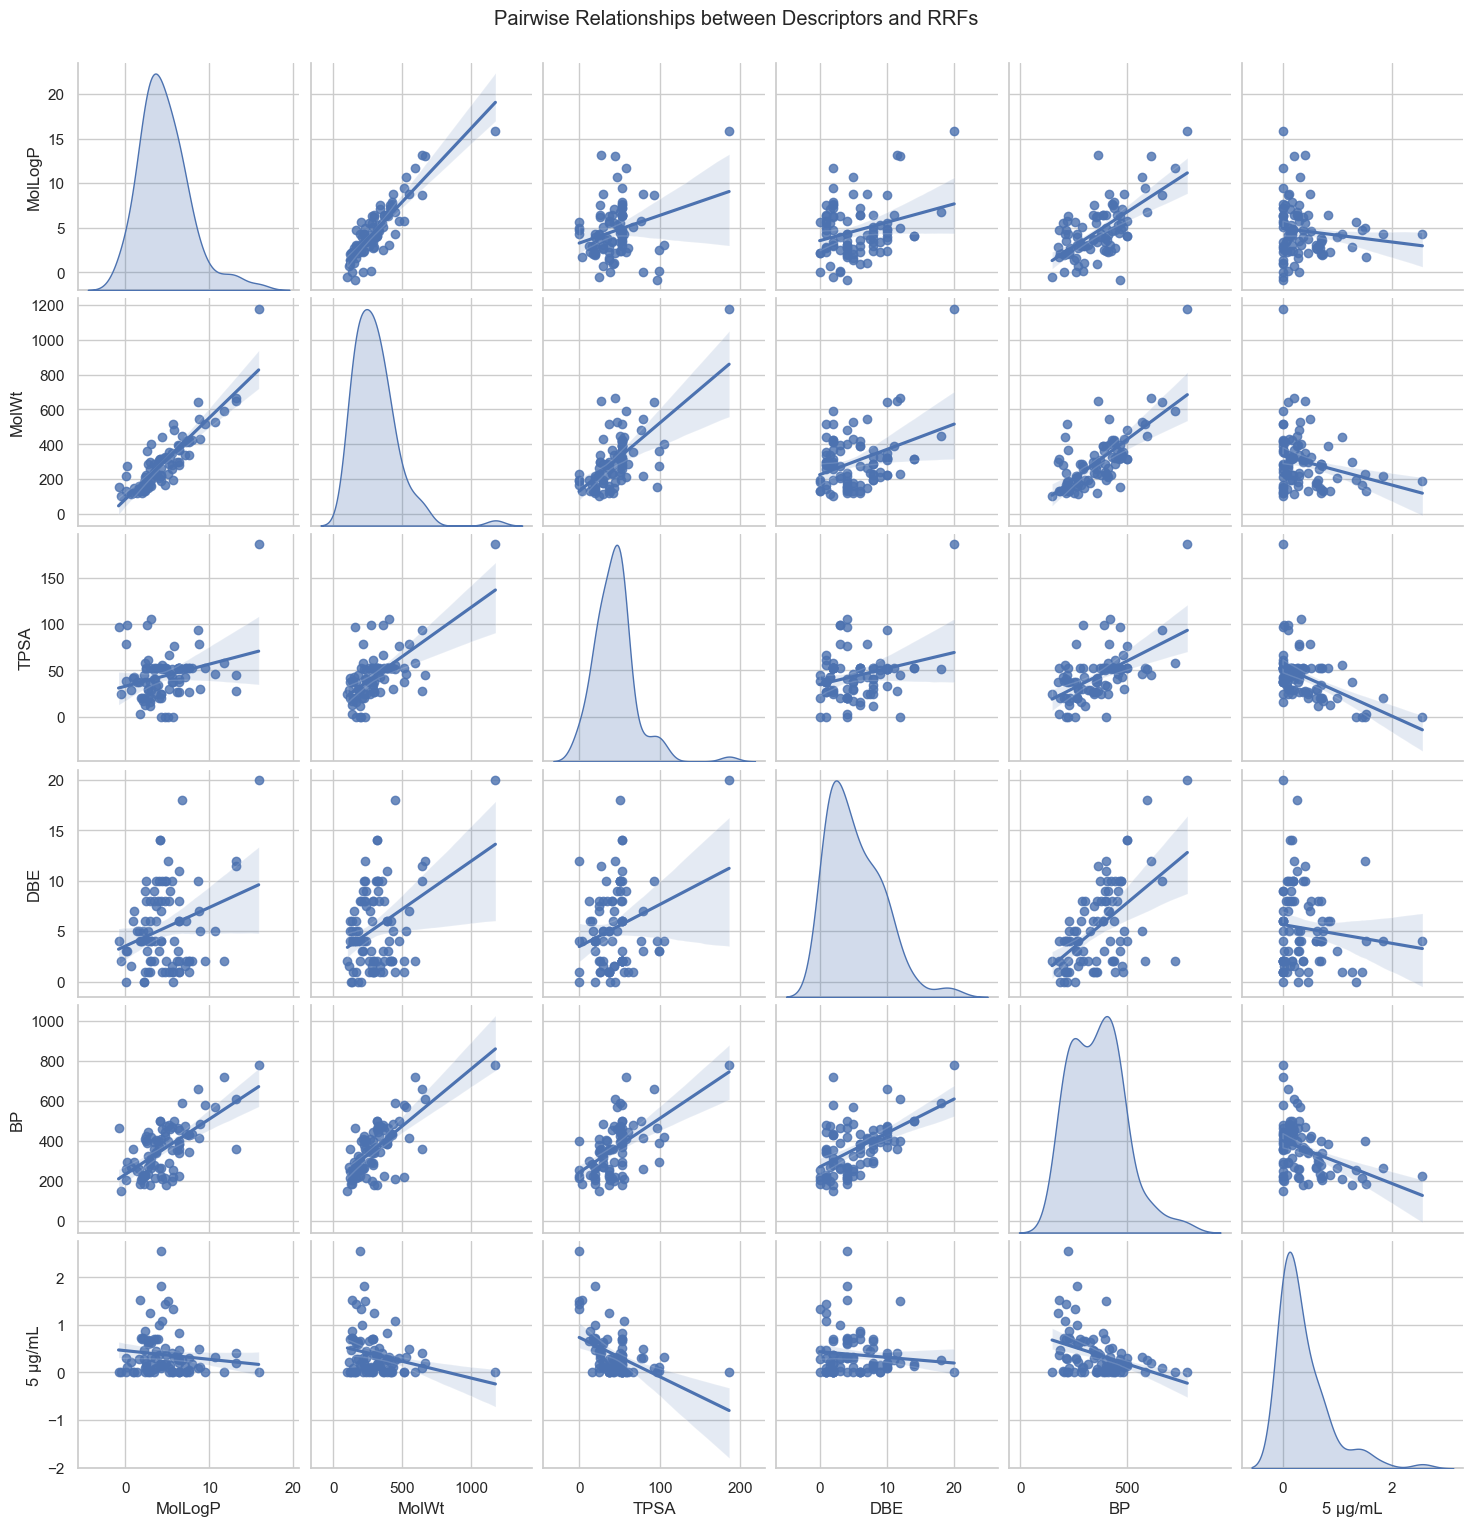

In [70]:
sns.pairplot(df_final, vars=['MolLogP', 'MolWt', 'TPSA', 'DBE', 'BP', '5 µg/mL'], kind='reg', diag_kind='kde')
plt.suptitle('Pairwise Relationships between Descriptors and RRFs', y=1.02)
plt.show()

### Multiple imputation for missing values

I selected relevant descriptors in addition to the ones provided by the CLAP list. Another version exist with all predictors.

In [71]:
selected_descriptors = [
    'ExactMolWt', 'TPSA', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 
    'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 
    'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 
    'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 
    'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 
    'RingCount', 'MolLogP', 'MolMR']

original_columns = df.columns.tolist()
cols_to_keep = original_columns + selected_descriptors

df_subset = df_final[df_final.columns.intersection(cols_to_keep)] 
df_subset

,Code,IUPAC name,CAS #,Empirical Formula,DBE,MW,BP,pKa,logP,Refractive Index,...,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR
0,RM1,"[3-[3-(3,5-ditert-butyl-4-hydroxyphenyl)propan...",6683-19-8,C73H108O12,20.0,1177.6,779.0,11.71,23.00,NaN,...,12.0,4.0,12.0,20.0,0.0,0.0,0.0,4.0,15.87920,341.5802
1,RM2,"octadecyl 3-(3,5-ditert-butyl-4-hydroxyphenyl)...",2082-79-3,C35H62O3,5.0,530.9,568.0,12.33,13.93,NaN,...,3.0,1.0,3.0,20.0,0.0,0.0,0.0,1.0,10.72450,164.3328
2,RM3,"tris(2,4-ditert-butylphenyl) phosphite",31570-04-4,C42H63O3P,11.5,646.9,361.0,NaN,17.56,NaN,...,3.0,0.0,4.0,6.0,0.0,0.0,0.0,3.0,13.23530,200.3300
3,RM4,"2,6-ditert-butyl-4-methylphenol",128-37-0,C15H24O,4.0,220.4,265.0,12.75,5.30,1.499,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,4.29562,70.2438
4,RM5,"2,4-ditert-butylphenol",96-76-4,C14H22O,3.0,206.3,264.0,11.56,5.19,1.499,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.98720,65.5068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,RM101,2-hydroxy-2-methyl-1-phenylpropan-1-one,7473-98-5,C10H12O2,5.0,164.2,260.8,13.23,1.13,1.533,...,2.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.64020,47.0703
88,RM102,2-phenylpropan-2-ol,617-94-7,C9H12O,4.0,136.2,202.0,14.49,1.73,1.518,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.91400,41.6868
89,RM103,dodec-1-ene,112-41-4,C12H24,1.0,168.3,213.9,NaN,6.62,1.431,...,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,4.70320,57.4240
90,RM105,dodecyl 3-(3-dodecoxy-3-oxopropyl)sulfanylprop...,123-28-4,C30H58O4S,2.0,514.8,580.8,NaN,12.88,1.472,...,5.0,0.0,5.0,28.0,0.0,0.0,0.0,0.0,9.42800,152.1650


In [72]:
missing_data = df_subset.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

print(missing_data)


pKa                 27
Refractive Index     3
BP                   1
dtype: int64


Missing values exist for `pKA` (27),  `Refractive Index`(3), `BP`(1).
Values for RI and BP will be imputed using Multiple Imputation. pKA will not be used in the models.

In [73]:
X = df_subset.drop(['5 µg/mL', 'IUPAC name', 'CAS #', 'Empirical Formula', '10 µg/mL', '20 µg/mL', 'Code', 'pKa', 'SMILES'] , axis=1) # Features without the 5 µg/mL RRF
y = df_subset['5 µg/mL'] # outcome

# Multiple Imputation using IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=42)
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Impute and Scale (for Elastic Net and SVM)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Keep as DataFrames for feature selection reference
feature_names = X.columns
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

## 4. Feature engineering

This is done via fitting a linear regression using Elastic Net regression.
First we find the ideal alpha and l1_ratio using grid search. then we fit the Elastic regression with the best parameters, and features.

In [74]:
param_grid = {
    'alpha': np.logspace(-4, 1, 20),
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 1.0] 
}
enet = ElasticNet(random_state=42, max_iter=100000)

grid_search = GridSearchCV(enet, param_grid, cv=5, scoring='r2') 
grid_search.fit(X_train_df, y_train)

best_enet = grid_search.best_estimator_
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Best L1 Ratio: {grid_search.best_params_['l1_ratio']}")

coefs = best_enet.coef_
selected_features = feature_names[coefs != 0]

print(f"Selected Features ({len(selected_features)}): {list(selected_features)}")

# Filter datasets to selected features only
X_train_sel = X_train_df[selected_features]
X_test_sel = X_test_df[selected_features]


Best Alpha: 0.4832930238571752
Best L1 Ratio: 0.1
Selected Features (7): ['BP', 'Refractive Index', 'TPSA', 'NHOHCount', 'NOCount', 'NumHDonors', 'NumRotatableBonds']


## 5. Model Selection

As we have a continuous outcome: we will fit three models : \\
Elastic regression (parametric) \\
Random Forests (non-parametric)  \\
Support Vector Machines (non-parametric) \\

They will all be trained on the 7 selected features, namely :
'BP', 'Refractive Index', 'TPSA', 'NHOHCount', 'NOCount', 'NumHDonors', 'NumRotatableBonds'

## 6. Model training

### ELastic Net Regression

In [75]:
enet = ElasticNet(random_state=42, max_iter=10000, alpha=0.04281332398719392, l1_ratio=0.9)
enet.fit(X_train_sel, y_train)

,alpha,0.04281332398719392
,l1_ratio,0.9
,fit_intercept,True
,precompute,False
,max_iter,10000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


### Random Forest

In [76]:
RF_model = RandomForestRegressor(n_estimators=100,
                   random_state=42, n_jobs=-1)
RF_model.fit(X_train_sel, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Support Vector Machine

In [77]:
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_sel, y_train)


,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [78]:
models = {
    'ElasticNet': enet,
    'Random Forest': RF_model,
    'SVM': svm_model
}

## 7. Model Evaluation

In [79]:
results_list = []

for name, model in models.items():
    # Make predictions
    predictions = model.predict(X_test_sel)
    
    # Calculate metrics
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    results_list.append({
        'Model': name,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    })

# Create a summary table
df_results = pd.DataFrame(results_list)
print(df_results)

           Model        R2       MAE      RMSE
0     ElasticNet  0.279043  0.326291  0.409752
1  Random Forest  0.664515  0.228685  0.279514
2            SVM  0.757782  0.186326  0.237503


## 8. Model optimisation for Random Forest and SVM

Elastic Regression was already optimised during the feature engineering. Therefore, we focus the hyperparameter tuning for RF and SVM.

The strategy is to use a Bayesian optimization (Optuna), to ensure that all parameters will optimise the objective function (maximizing R²)

In [80]:
def objective_svm(trial):
    c = trial.suggest_float('C', 1e-3, 1e2, log=True)
    epsilon = trial.suggest_float('epsilon', 1e-3, 0.5, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    model = SVR(C=c, epsilon=epsilon, gamma=gamma)
    
    score = cross_val_score(model, X_train_sel, y_train, cv=5, scoring='r2').mean()
    return score

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=30)

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    score = cross_val_score(model, X_train_sel, y_train, cv=5, scoring='r2').mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

[I 2026-01-06 21:21:23,615] A new study created in memory with name: no-name-351c0912-cb41-4ea6-909b-ae7c203e1179
[I 2026-01-06 21:21:23,640] Trial 0 finished with value: 0.17574761938019812 and parameters: {'C': 0.054732123845389155, 'epsilon': 0.015288964915311615, 'gamma': 'scale'}. Best is trial 0 with value: 0.17574761938019812.
[I 2026-01-06 21:21:23,670] Trial 1 finished with value: 0.2780231990936299 and parameters: {'C': 0.14649928856177494, 'epsilon': 0.004449538692180627, 'gamma': 'scale'}. Best is trial 1 with value: 0.2780231990936299.
[I 2026-01-06 21:21:23,690] Trial 2 finished with value: 0.2507263091144707 and parameters: {'C': 1.1274425786769873, 'epsilon': 0.04638863861065577, 'gamma': 'scale'}. Best is trial 1 with value: 0.2780231990936299.
[I 2026-01-06 21:21:23,722] Trial 3 finished with value: -0.03252614722220466 and parameters: {'C': 7.30085604991813, 'epsilon': 0.2996874986769405, 'gamma': 'auto'}. Best is trial 1 with value: 0.2780231990936299.
[I 2026-01-06

In [81]:
optuna.visualization.plot_optimization_history(study_svm)

In [82]:
optuna.visualization.plot_param_importances(study_svm)


In [83]:
optuna.visualization.plot_optimization_history(study_rf)

In [84]:
optuna.visualization.plot_param_importances(study_rf)

### Model evaluation on the Optimized Models

In [85]:
# For Random Forest
best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42)
best_rf.fit(X_train_sel, y_train)

# For SVM
best_svm = SVR(**study_svm.best_params)
best_svm.fit(X_train_sel, y_train)

models = {
    'Random Forest': best_rf,
    'SVM': best_svm
}

results_list = []

for name, model in models.items():
    predictions = model.predict(X_test_sel)
    
    # Calculate metrics
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    results_list.append({
        'Model': name,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    })

df_results = pd.DataFrame(results_list)
print(df_results)

           Model        R2       MAE      RMSE
0  Random Forest  0.690883  0.215652  0.268304
1            SVM  0.737507  0.194989  0.247244


Random Forest and SVM yield similar R² and RMSE. For better interpretability of the results, it is decided to take RF as final model.

### Importance and Data Visualisation of a DT

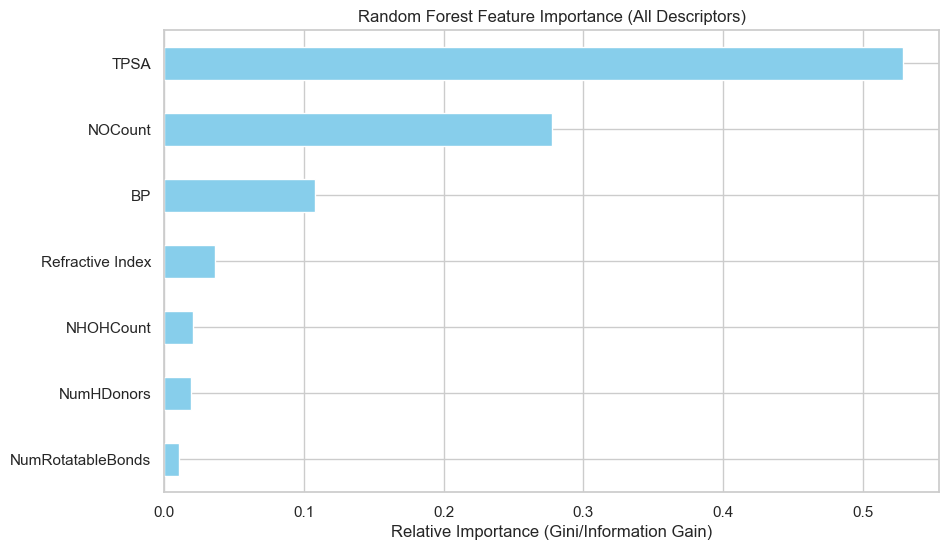

In [86]:
importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=X_train_sel.columns)

plt.figure(figsize=(10, 6))
feat_importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Random Forest Feature Importance (All Descriptors)')
plt.xlabel('Relative Importance (Gini/Information Gain)')
plt.show()

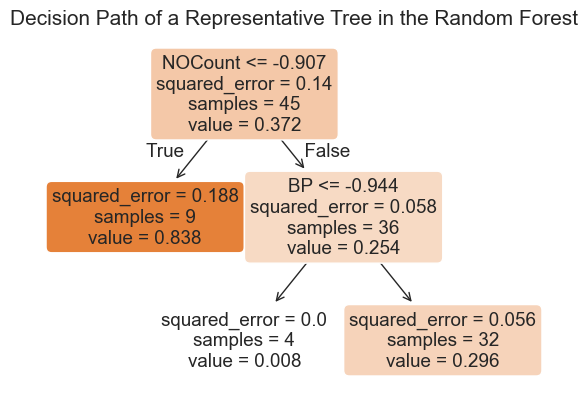

In [87]:
plot_tree(best_rf.estimators_[25],
          feature_names=selected_features, 
          filled=True, 
          rounded=True)

plt.title("Decision Path of a Representative Tree in the Random Forest", fontsize=15)
plt.show()

## Save the model

In [88]:
import joblib
joblib.dump(best_rf, 'rf_rrf_model.joblib')
joblib.dump(selected_features, 'features.joblib')

['features.joblib']

## Save the final dataset 

In [89]:
df_subset['BP'].describe()



count     91.000000
mean     359.889011
std      127.047844
min      148.300000
25%      259.400000
50%      359.400000
75%      435.500000
max      779.000000
Name: BP, dtype: float64

In [90]:
df_subset.to_csv("final_model_data.csv", index=False)